In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Step 1: Load the dataset
# Reading the CSV file into a pandas DataFrame
df = pd.read_csv('Airline_Delay_Cause.csv')


In [10]:
# Step 2: Exploratory Data Analysis (EDA)
# Displaying the first few rows to understand the data structure
print("First 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   year  month carrier       carrier_name airport  \
0  2023     12      9E  Endeavor Air Inc.     ABE   
1  2023     12      9E  Endeavor Air Inc.     AEX   
2  2023     12      9E  Endeavor Air Inc.     AGS   
3  2023     12      9E  Endeavor Air Inc.     ALB   
4  2023     12      9E  Endeavor Air Inc.     ATL   

                                        airport_name  arr_flights  arr_del15  \
0  Allentown/Bethlehem/Easton, PA: Lehigh Valley ...         72.0        5.0   
1           Alexandria, LA: Alexandria International         62.0        7.0   
2        Augusta, GA: Augusta Regional at Bush Field         95.0       10.0   
3                   Albany, NY: Albany International         23.0        2.0   
4  Atlanta, GA: Hartsfield-Jackson Atlanta Intern...       2111.0      256.0   

   carrier_ct  weather_ct  ...  security_ct  late_aircraft_ct  arr_cancelled  \
0        2.46        1.00  ...          0.0              0.81            0.0   
1        4.

In [11]:
# Checking data types and missing values
print("\nData Info:")
print(df.info())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179338 entries, 0 to 179337
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 179338 non-null  int64  
 1   month                179338 non-null  int64  
 2   carrier              179338 non-null  object 
 3   carrier_name         179338 non-null  object 
 4   airport              179338 non-null  object 
 5   airport_name         179338 non-null  object 
 6   arr_flights          178997 non-null  float64
 7   arr_del15            178747 non-null  float64
 8   carrier_ct           178997 non-null  float64
 9   weather_ct           178997 non-null  float64
 10  nas_ct               178997 non-null  float64
 11  security_ct          178997 non-null  float64
 12  late_aircraft_ct     178997 non-null  float64
 13  arr_cancelled        178997 non-null  float64
 14  arr_diverted         178997 non-null  float64
 15  arr_d

In [12]:
# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                year          month    arr_flights      arr_del15  \
count  179338.000000  179338.000000  178997.000000  178747.000000   
mean     2019.480082       6.485725     327.816969      58.709086   
std         2.410204       3.463516     931.001446     164.378035   
min      2015.000000       1.000000       1.000000       0.000000   
25%      2018.000000       3.000000      41.000000       6.000000   
50%      2020.000000       6.000000      89.000000      15.000000   
75%      2022.000000       9.000000     218.000000      40.000000   
max      2023.000000      12.000000   21977.000000    4176.000000   

          carrier_ct     weather_ct         nas_ct    security_ct  \
count  178997.000000  178997.000000  178997.000000  178997.000000   
mean       18.572643       2.035742      17.094929       0.145307   
std        47.389651       6.894812      56.279604       0.702149   
min         0.000000       0.000000       0.000000       0.000000   
25%         

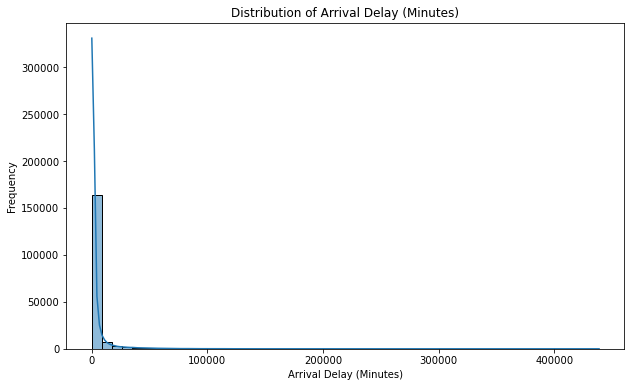

In [13]:
# Visualizing distribution of target variable for regression (arr_delay)
plt.figure(figsize=(10, 6))  # Set figure size to 10x6 inches
sns.histplot(df['arr_delay'], bins=50, kde=True)  # Create histogram with 50 bins and kernel density estimate
plt.title('Distribution of Arrival Delay (Minutes)')  # Set plot title
plt.xlabel('Arrival Delay (Minutes)')  # Set x-axis label
plt.ylabel('Frequency')  # Set y-axis label
plt.show()  # Display the plot
plt.savefig('arr_delay_distribution.png')
plt.close()

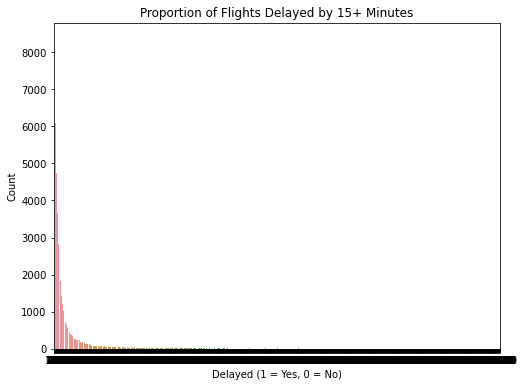

In [14]:
# Visualizing proportion of delayed flights (arr_del15)
plt.figure(figsize=(8, 6))
sns.countplot(x='arr_del15', data=df)
plt.title('Proportion of Flights Delayed by 15+ Minutes')
plt.xlabel('Delayed (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()
plt.savefig('arr_del15_proportion.png')
plt.close()

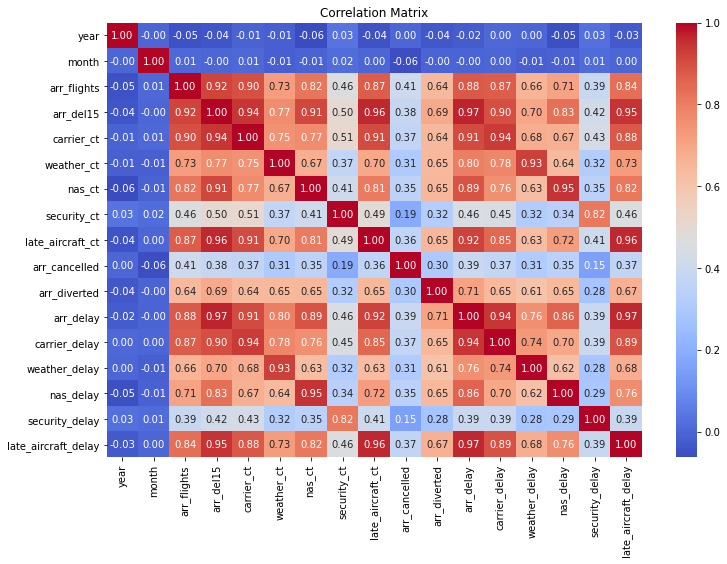

In [15]:
# Correlation matrix for numerical features
plt.figure(figsize=(12, 8))
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
plt.savefig('correlation_matrix.png')
plt.close()

In [16]:
# Step 3: Data Cleaning
# Checking for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
year                     0
month                    0
carrier                  0
carrier_name             0
airport                  0
airport_name             0
arr_flights            341
arr_del15              591
carrier_ct             341
weather_ct             341
nas_ct                 341
security_ct            341
late_aircraft_ct       341
arr_cancelled          341
arr_diverted           341
arr_delay              341
carrier_delay          341
weather_delay          341
nas_delay              341
security_delay         341
late_aircraft_delay    341
dtype: int64


In [17]:
# Dropping rows with missing values (if any)
df = df.dropna()

In [18]:
# Dropping irrelevant columns (e.g., identifiers, names)
columns_to_drop = ['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name']
df = df.drop(columns=columns_to_drop, errors='ignore')


In [19]:
# Step 4: Check if Classification Dataset is Balanced
# Calculating the proportion of each class in arr_del15
class_balance = df['arr_del15'].value_counts(normalize=True)
print("\nClass Balance for arr_del15:")
print(class_balance)


Class Balance for arr_del15:
0.0       0.046843
1.0       0.044907
2.0       0.041534
3.0       0.039268
4.0       0.038932
            ...   
1613.0    0.000006
1887.0    0.000006
1963.0    0.000006
1525.0    0.000006
1174.0    0.000006
Name: arr_del15, Length: 1692, dtype: float64


In [20]:
# Step 5: Feature Selection for Regression
# Defining features and target for regression
X_reg = df.drop(columns=['arr_delay', 'arr_del15'])  # Exclude target and classification label
y_reg = df['arr_delay']

# Using Random Forest to get feature importance
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_reg, y_reg)

RandomForestRegressor(random_state=42)

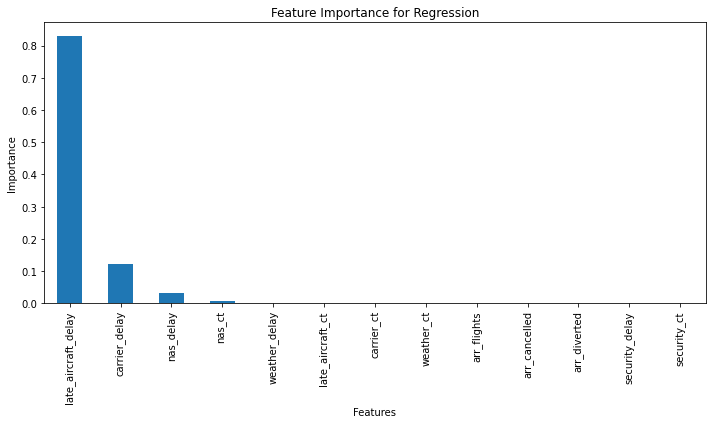

In [21]:
# Plotting feature importance
feature_importance_reg = pd.Series(rf_reg.feature_importances_, index=X_reg.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importance_reg.plot(kind='bar')
plt.title('Feature Importance for Regression')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
plt.savefig('feature_importance_reg.png')
plt.close()

In [22]:
# Selecting top features (e.g., top 8)
top_features_reg = feature_importance_reg.head(8).index.tolist()
print("\nSelected Features for Regression:", top_features_reg)
X_reg = X_reg[top_features_reg]


Selected Features for Regression: ['late_aircraft_delay', 'carrier_delay', 'nas_delay', 'nas_ct', 'weather_delay', 'late_aircraft_ct', 'carrier_ct', 'weather_ct']


In [23]:
# Step 6: Regression Model with K-Fold Cross-Validation
# Splitting data into training and testing sets
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Initializing Random Forest Regressor
reg_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Performing 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(reg_model, X_reg, y_reg, cv=kf, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-cv_scores)
print("\nCross-Validation RMSE Scores:", rmse_cv)
print("Mean CV RMSE:", rmse_cv.mean())


Cross-Validation RMSE Scores: [ 724.98219321  730.37775143  661.74671772  713.09157574 1145.22938163]
Mean CV RMSE: 795.0855239471477


In [24]:
# Training the model on the full training set
reg_model.fit(X_reg_train, y_reg_train)

# Predicting on test set
y_reg_pred = reg_model.predict(X_reg_test)

In [25]:
# Evaluating the model
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
mae = mean_absolute_error(y_reg_test, y_reg_pred)
r2 = r2_score(y_reg_test, y_reg_pred)
print("\nRegression Model Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


Regression Model Evaluation:
RMSE: 665.10
MAE: 86.02
R²: 1.00


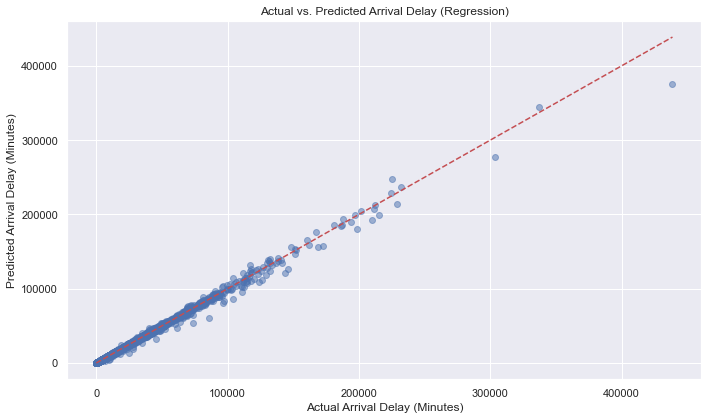

In [26]:
# Visualizing Actual vs. Predicted for Regression
plt.figure(figsize=(10, 6))
sns.set_theme()
plt.scatter(y_reg_test, y_reg_pred, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--')
plt.xlabel('Actual Arrival Delay (Minutes)')
plt.ylabel('Predicted Arrival Delay (Minutes)')
plt.title('Actual vs. Predicted Arrival Delay (Regression)')
plt.tight_layout()
plt.show()
plt.savefig('actual_vs_predicted_reg.png')
plt.close()

In [27]:
!pip install shap


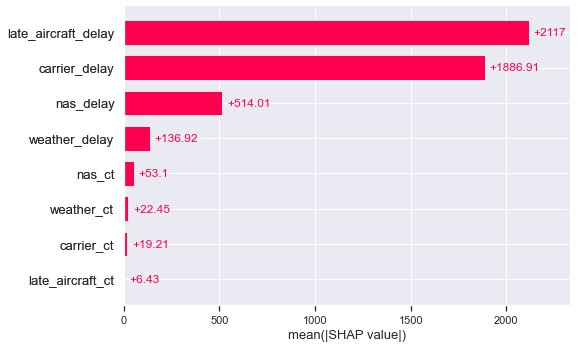

In [28]:
import shap

# Sample a small set (safe)
sample_X = X_reg_test.sample(n=100, random_state=42)

# Use SHAP's tree explainer
explainer = shap.TreeExplainer(reg_model)

# Compute SHAP values
shap_values = explainer.shap_values(sample_X)

# Bar plot: mean(|SHAP|) per feature
shap.plots.bar(shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=sample_X, feature_names=sample_X.columns))


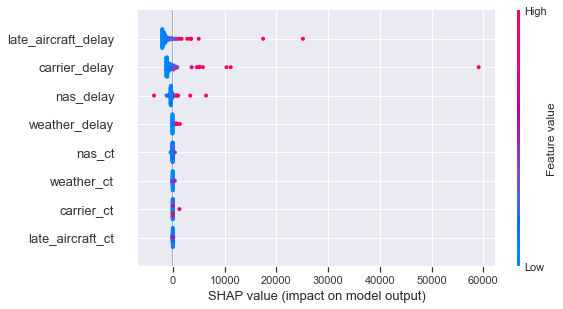

In [29]:
shap.plots.beeswarm(shap.Explanation(values=shap_values,
                                     base_values=explainer.expected_value,
                                     data=sample_X,
                                     feature_names=sample_X.columns))



In [33]:
#OAI
# Define feature weights (higher = more controllable)
oai_weights = {
    'carrier_delay': 2.0,
    'late_aircraft_delay': 2.0,
    'nas_delay': 1.0,
    'weather_delay': 0.5,
    'security_delay': 0.3  # optional if used
}

# Use the test set (X_reg_test) to compute weighted contributions
# NOTE: sample_X if you're using only sampled rows for SHAP/OAI
weighted_contributions = []

for idx, row in X_reg_test.iterrows():
    score = 0
    for feature, weight in oai_weights.items():
        if feature in row:
            score += row[feature] * weight
    weighted_contributions.append(score)

# Convert to numpy array
import numpy as np
oai_values = np.array(weighted_contributions)

# Print average OAI for the test set
print(f"Average Operational Adjustability Index (OAI): {np.mean(oai_values):.2f}")


Average Operational Adjustability Index (OAI): 6403.07
